In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib import scimath as SM

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""

.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

""")

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = np.nanargmin(np.abs(array - value))
    return array[idx]

# Characteristic equation for TM and TE modes

In [5]:
def adguide(nf, nc, ns, lmbd, h, mode, m, r):
  mmax = 5
  tol = 1e-10

  if (mode=='TM'):
    pc = (nf/nc)**2
    ps = (nf/ns)**2
  else:
    pc = 1
    ps = 1

  delta = (ns**2-nc**2)/(nf**2-ns**2)
  k0 = 2*np.pi/lmbd
  NA = np.sqrt(nf**2-ns**2)
  R = k0*h*NA

  if m == 'none':
    M = int(np.ceil((2*R-np.arctan(pc*np.sqrt(delta)))/np.pi))
    m = np.arange(0,M)

  gamma_c = SM.sqrt((k0*(nf-nc))**2)
  gamma_s = SM.sqrt((k0*(nf-ns))**2)
  Gc = gamma_c
  Gs = gamma_s
  k   = gamma_c
  Kc = k0*SM.sqrt(n1**2-nc**2)
  Ks = k0*SM.sqrt(n1**2-ns**2)

  Nit = 1
  while True:
    #k_new = 2/a*(m * np.pi + np.arctan((pc*ps*gamma_c*gamma_s-k**2)-Gc*Gs)/(k*(pc*gamma_c+ps*gamma_s)))
    #k_new = ((pc*ps*Kc*Ks)**2-(Gc*Gs)**2*(np.cos(k*h))**2+((pc*ps)**2-1)*k**4)
    #k_new = SM.sqrt(k_new/(((pc*ps)**2)*(Kc**2+Ks**2)+2*Gc*Gs*np.cos(k*h)))
    k_new = Kc/(SM.sqrt(1+(pc**-2)*(np.tan(k*h/2))**2))
    k_new = r*k_new + (1-r)*k
    if np.any(np.abs(k_new-k) <= tol):
        break
    Nit = Nit + 1
    k = k_new
    gamma_c = SM.sqrt((k0*(nf-nc))**2 - k**2)
    gamma_s = SM.sqrt((k0*(nf-ns))**2 - k**2)
    Gc = SM.sqrt(k**2+(pc*gamma_c)**2)
    Gs = SM.sqrt(k**2+(ps*gamma_s)**2)
    if Nit > 1000:
        break

  return k

# Initial parameters

## Material and waveguide

In [6]:
n1 = 1.5    # core
n2 = 1.499  # cladding
n3 = n2     # cladding
n4 = n2     # cladding
n5 = n2     # cladding
a = 5e-6
b = 10e-6

In [7]:
p2 = (n1/n2)**2
p3 = (n1/n3)**2
p4 = (n1/n4)**2
p5 = (n1/n5)**2

numOfPoints = 1000

lambda_min = 0.5e-6
lambda_max = 2.0e-6

## Material, frequency and modal parameters

In [8]:
k0 = 2*np.pi/lambda_min

In [9]:
kx = np.linspace(0, k0*SM.sqrt(n1**2-n2**2), numOfPoints)
ky = np.linspace(0, k0*SM.sqrt(n1**2-n2**2), numOfPoints)
gamma_2 = SM.sqrt(k0**2*(n1**2-n2**2)-kx**2)
gamma_3 = SM.sqrt(k0**2*(n1**2-n3**2)-kx**2)
gamma_4 = SM.sqrt(k0**2*(n1**2-n4**2)-ky**2)
gamma_5 = SM.sqrt(k0**2*(n1**2-n5**2)-ky**2)

# E$^x_{nm}$ modes

## Characteristic equation

\begin{equation}
        \tan \left( k_x a\right) = \frac{k_x\left( p_3 \gamma_3 + p_2 \gamma_2 \right)}{k_x^2 - p_2 p_3 \gamma_2 \gamma_3}, \quad p_2 = \frac{n_1^2}{n_2^2}, \quad p_3 = \frac{n_1^2}{n_3^2}, \quad \tan \left( k_y b\right) = \frac{k_y\left( \gamma_4 + \gamma_5 \right)}{k_y^2 - \gamma_4 \gamma_5}
    \end{equation}
    \begin{equation}
        \tan \phi_x = - \frac{k_x}{p_3 \gamma_3} \qquad \tan \phi_y = -\frac{\gamma_5}{k_y}
    \end{equation}
    \begin{equation}
        V = k_0 d \sqrt{n_1^2 - n_d^2}
    \end{equation}

In [10]:
# Ex_nm modes
f1 = np.tan(ky*b)
f1 = f1 - ky*(gamma_4+gamma_5)/(ky**2 - gamma_4*gamma_5)
f1[:-1][np.diff(f1) > 5] = np.nan

kySol_exg = adguide(n1, n4, n5, lambda_min, b, 'TE', 'none', 0.1)

In [11]:
f2 = np.tan(kx*a)
f2 = f2 - kx*(gamma_2*p2 + gamma_3*p3)/(kx**2 - p2*p3*gamma_2*gamma_3)
f2[:-1][np.diff(f2) > 5] = np.nan

kxSol_exg = adguide(n1, n2, n3, lambda_min, a, 'TM', 'none', 0.5)

### Graphical solution

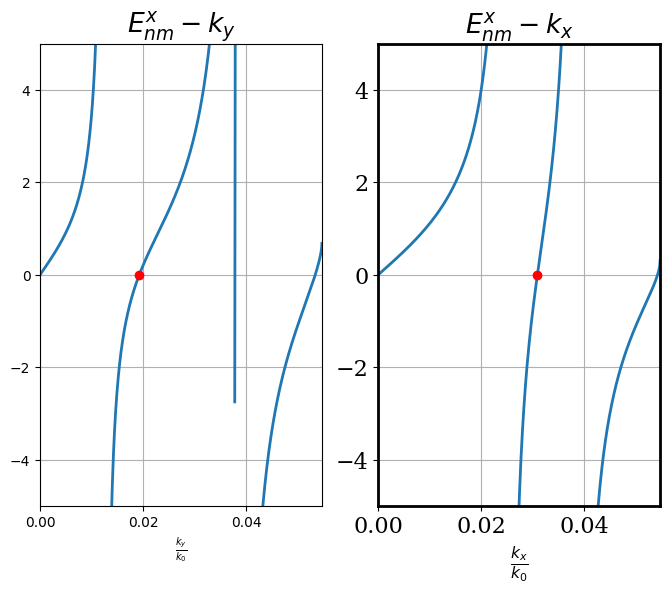

In [12]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

fig1 = plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.plot(ky/k0, f1, linewidth = 2)
plt.plot(kySol_exg/k0, np.zeros(np.size(kySol_exg)), 'ro')
plt.ylim([-5,5])
plt.xlim([0, SM.sqrt(n1**2-n2**2)])
plt.title(r'$E^x_{nm} - k_y$')
plt.xlabel(r'$\frac{k_y}{k_0}$')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(kx/k0, f2, linewidth = 2)
plt.plot(kxSol_exg/k0, np.zeros(np.size(kxSol_exg)), 'ro')
plt.ylim([-5,5])
plt.xlim([0, SM.sqrt(n1**2-n2**2)])
plt.title(r'$E^x_{nm} - k_x$')
plt.xlabel(r'$\frac{k_x}{k_0}$')
plt.grid(True)

### Numerical solution

In [25]:
lmbd = np.linspace(lambda_min, lambda_max, numOfPoints)
k0 = 2*np.pi/lmbd
Vv = k0 * np.min(np.array([a, b])) * np.sqrt(n1**2-find_nearest(np.array([n2, n3, n4, n5])**2, n1))
kySol_exn = adguide(n1, n4, n5, lmbd, b, 'TE', 0, 0.1)
kxSol_exn = adguide(n1, n2, n3, lmbd, a, 'TM', 0, 0.5)
beta_ex = np.sqrt((k0*n1)**2-kxSol_exn**2-kySol_exn**2)
bn_ex = ((beta_ex/k0)**2-n2**2)/(n1**2 - n2**2)

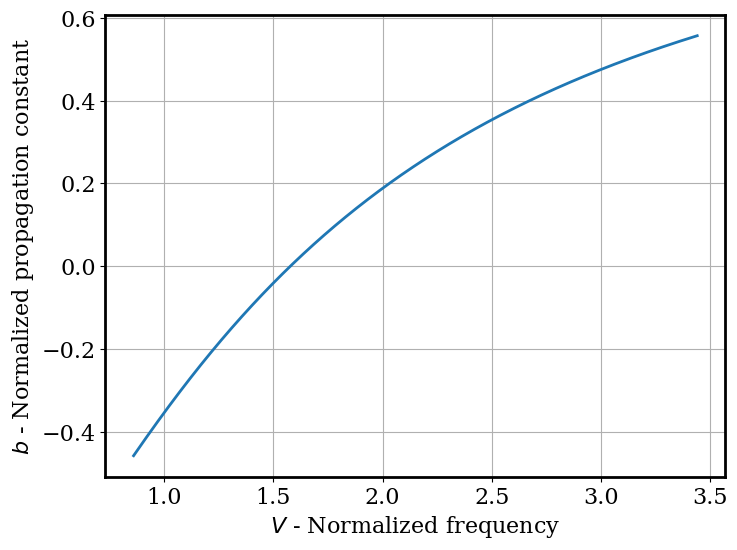

In [14]:
fig2 = plt.figure(figsize=(8,6))
plt.plot(Vv, bn_ex, linewidth = 2)
plt.xlabel(r'$V$ - Normalized frequency')
plt.ylabel(r'$b$ - Normalized propagation constant')
plt.grid(True)

## Field intensity

In [15]:
idxSol  = 0
gamma_2 = SM.sqrt(k0[idxSol]**2*(n1**2-n2**2)-kxSol_exn[idxSol]**2)
gamma_3 = SM.sqrt(k0[idxSol]**2*(n1**2-n3**2)-kxSol_exn[idxSol]**2)
gamma_4 = SM.sqrt(k0[idxSol]**2*(n1**2-n4**2)-kySol_exn[idxSol]**2)
gamma_5 = SM.sqrt(k0[idxSol]**2*(n1**2-n5**2)-kySol_exn[idxSol]**2)

phix = np.arctan(-kxSol_exn[idxSol]/(p3*gamma_3))
phiy = np.arctan(-gamma_5/kySol_exn[idxSol])

In [16]:
A1 = 1
A2 = np.sin(-kxSol_exn[idxSol] * a + phix )
A3 = np.sin(phix)
A4 = p4 * np.cos(kySol_exn[idxSol] * b + phiy)
A5 = p5 * np.cos(phiy)

Text(0.5, 0.5, 'y')

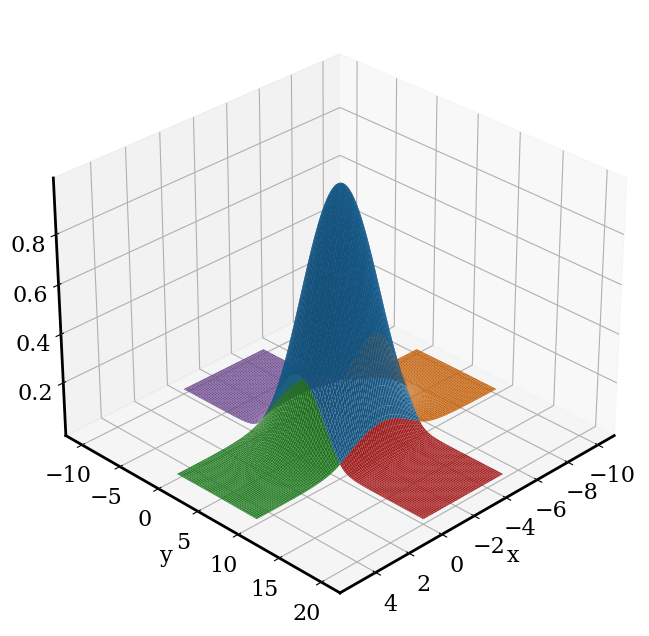

In [17]:
fig3, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (8,8))

x = np.linspace(-a, 0, 100)
y = np.linspace( 0, b, 100)
X,Y = np.meshgrid(x, y)
Z1  = A1 * np.sin(kxSol_exn[idxSol] * X + phix) * np.cos(kySol_exn[idxSol] * Y + phiy)
ax.plot_surface(1e6*X, 1e6*Y, Z1*np.conjugate(Z1))

x   = np.linspace(-2*a, -a, 100)
X,Y = np.meshgrid(x, y)
Z2  = A2 * np.exp(gamma_2 * (X + a)) * np.cos(kySol_exn[idxSol] * Y + phiy)
ax.plot_surface(1e6*X, 1e6*Y, Z2*np.conjugate(Z2))

x   = np.linspace(0, a, 100)
X,Y = np.meshgrid(x, y)
Z3  = A3 * np.exp(-gamma_3 * X) * np.cos(kySol_exn[idxSol] * Y + phiy)
ax.plot_surface(1e6*X, 1e6*Y, Z3*np.conjugate(Z3))

x = np.linspace(-a, 0, 100)
y = np.linspace(b, 2*b, 500)
X, Y = np.meshgrid(x, y)
Z4 = A4 * np.exp(-gamma_4 * (Y - b)) * np.sin(kxSol_exn[idxSol] * X + phix)
ax.plot_surface(1e6*X, 1e6*Y, Z4*np.conjugate(Z4))

y = np.linspace(-b, 0, 500)
X, Y = np.meshgrid(x, y)
Z5 = A5 * np.exp(gamma_5 * Y) * np.sin( kxSol_exn[idxSol] * X + phix)
ax.plot_surface(1e6*X, 1e6*Y, Z5*np.conjugate(Z5))

ax.view_init(30,45)
ax.set_xlabel('x')
ax.set_ylabel('y')

# E$^y_{nm}$ modes

In [18]:
k0 = 2*np.pi/lambda_min

In [19]:
kx = np.linspace(0, k0*SM.sqrt(n1**2-n2**2), numOfPoints)
ky = np.linspace(0, k0*SM.sqrt(n1**2-n2**2), numOfPoints)
gamma_2 = SM.sqrt(k0**2*(n1**2-n2**2)-kx**2)
gamma_3 = SM.sqrt(k0**2*(n1**2-n3**2)-kx**2)
gamma_4 = SM.sqrt(k0**2*(n1**2-n4**2)-ky**2)
gamma_5 = SM.sqrt(k0**2*(n1**2-n5**2)-ky**2)

## Characteristic equation

\begin{equation}
        \tan \left( k_x a\right) = \frac{k_x\left( \gamma_2 + \gamma_3 \right)}{k_x^2 - \gamma_2 \gamma_3}, \quad \tan \left( k_y b\right) = \frac{k_y\left( p_4 \gamma_4 + p_5 \gamma_5 \right)}{k_y^2 - p_4 p_5 \gamma_4 \gamma_5}, \quad p_4 = \frac{n_1^2}{n_4^2}, \quad p_5 = \frac{n_1^2}{n_5^2}
    \end{equation}
    \begin{equation}
        \tan \phi_x = \frac{\gamma_3}{k_x} \qquad \tan \phi_y = \frac{k_y}{p_5 \gamma_5}
    \end{equation}
    \begin{equation}
        V = k_0 d \sqrt{n_1^2 - n_d^2}
    \end{equation}

In [20]:
# Ey_nm modes
f3 = np.tan(kx*a)
f3 = f3 - kx*(gamma_2+gamma_3)/(kx**2 - gamma_2*gamma_3)
f3[:-1][np.diff(f3) > 5] = np.nan

kxSol_eyg = adguide(n1, n2, n3, lambda_min, a, 'TE', 'none', 0.1)

In [21]:
f4 = np.tan(ky*b)
f4 = f4 - ky*(gamma_4*p4 + gamma_5*p5)/(ky**2 - p4*p5*gamma_4*gamma_5)
f4[:-1][np.diff(f4) > 5] = np.nan

kySol_eyg = adguide(n1, n4, n5, lambda_min, b, 'TM', 'none', 0.1)

### Graphical solution

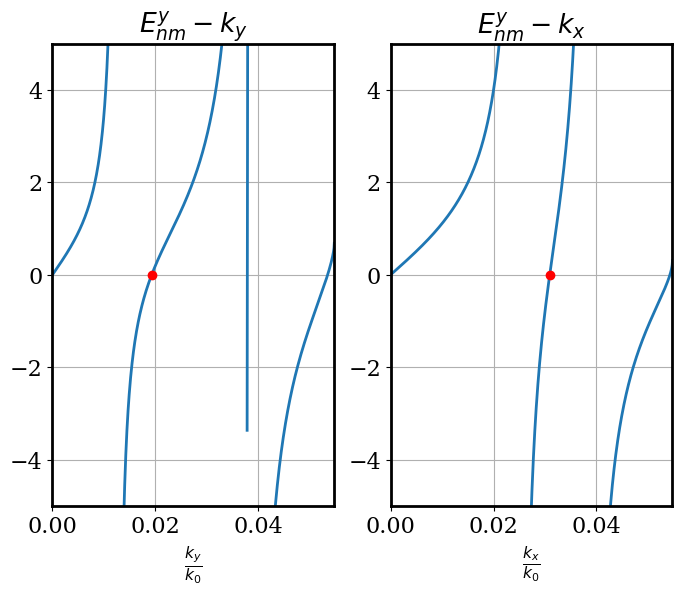

In [22]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

fig4 = plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.plot(ky/k0, f4, linewidth = 2)
plt.plot(kySol_eyg/k0, np.zeros(np.size(kySol_eyg)), 'ro')
plt.ylim([-5,5])
plt.xlim([0, SM.sqrt(n1**2-n2**2)])
plt.title(r'$E^y_{nm} - k_y$')
plt.xlabel(r'$\frac{k_y}{k_0}$')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(kx/k0, f3, linewidth = 2)
plt.plot(kxSol_eyg/k0, np.zeros(np.size(kxSol_eyg)), 'ro')
plt.ylim([-5,5])
plt.xlim([0, SM.sqrt(n1**2-n2**2)])
plt.title(r'$E^y_{nm} - k_x$')
plt.xlabel(r'$\frac{k_x}{k_0}$')
plt.grid(True)

### Numerical solution

In [23]:
lmbd = np.linspace(lambda_min, lambda_max, numOfPoints)
k0 = 2*np.pi/lmbd
Vv = k0 * np.min(np.array([a, b])) * np.sqrt(n1**2-find_nearest(np.array([n2, n3, n4, n5])**2, n1))
kySol_eyn = adguide(n1, n4, n5, lmbd, b, 'TE', 0, 0.1)
kxSol_eyn = adguide(n1, n2, n3, lmbd, a, 'TM', 0, 0.5)
beta_ey = np.sqrt((k0*n1)**2-kxSol_eyn**2-kySol_eyn**2)
bn_ey = ((beta_ex/k0)**2-n2**2)/(n1**2 - n2**2)

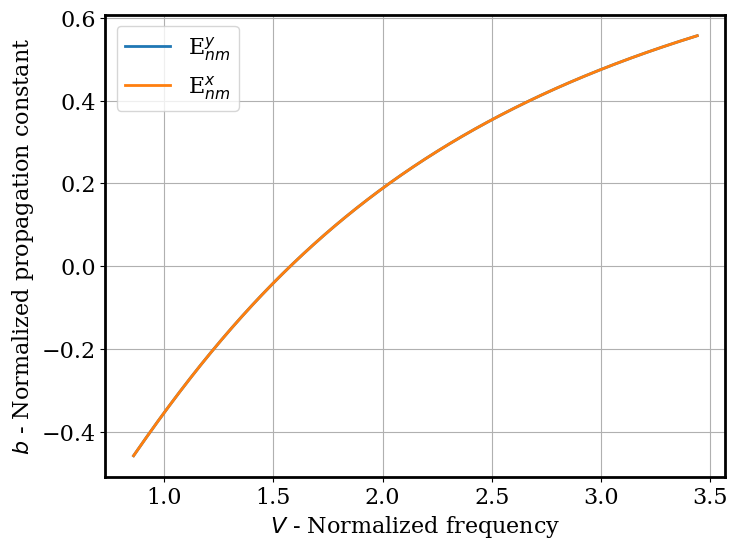

In [24]:
fig5 = plt.figure(figsize=(8,6))
plt.plot(Vv, bn_ey, linewidth = 2, label = r'E$^y_{nm}$')
plt.plot(Vv, bn_ex, linewidth = 2, label = r'E$^x_{nm}$')
plt.xlabel(r'$V$ - Normalized frequency')
plt.ylabel(r'$b$ - Normalized propagation constant')
plt.grid(True)
plt.legend()